In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras

In [2]:
cifar_100 = tf.keras.datasets.cifar100

In [3]:
(X_train, y_train), (X_test, y_test) = cifar_100.load_data()

169017344/169001437 [==============================] - 7s 0us/step


In [4]:
print(f"size of train data {len(X_train)}")
print(f"size of test data {(len(X_test))}")

size of train data 50000
size of test data 10000


##visualization

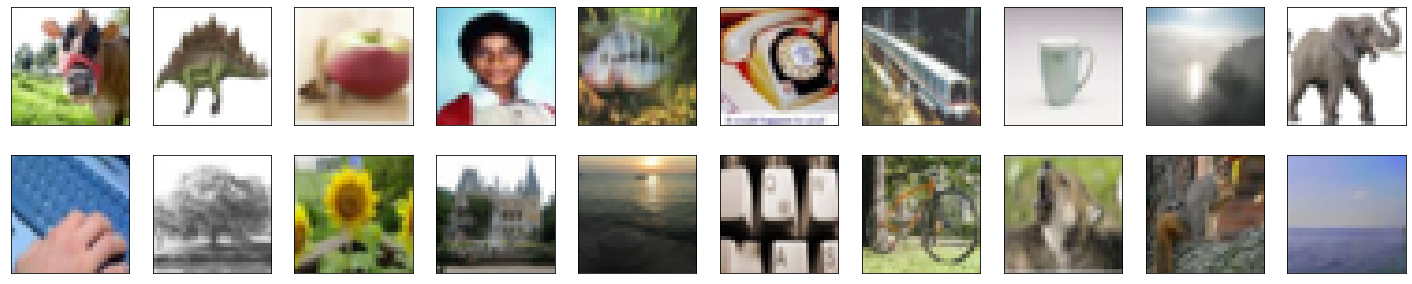

In [5]:
fig = plt.figure(figsize=(25,5))
for i in range(20):
  ax = fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(X_train[i]))

##Rescale the Images

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [7]:
num_classes = len(np.unique(y_train))
num_classes

100

In [8]:
from keras.utils import np_utils

# one-hot encode the labels

y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

# break training set into training and validation sets

x_train , x_valid = X_train[5000:], X_train[:5000]
y_train , y_valid = y_train[5000:], y_train[:5000]

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


Importing Pre-trained Model

In [9]:
x_train[1].shape

(32, 32, 3)

In [14]:
resnet_model = tf.keras.models.Sequential()

pretrained_model = tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(32, 32, 3),pooling='avg',classes=num_classes)

for layer in pretrained_model.layers:
  layer.trainable=False

In [15]:
resnet_model.add(pretrained_model)
resnet_model.add(tf.keras.layers.Dense(units=128,activation='relu'))
resnet_model.add(tf.keras.layers.Dropout(rate=0.25))
resnet_model.add(tf.keras.layers.BatchNormalization())
resnet_model.add(tf.keras.layers.Dense(units=num_classes,activation='softmax'))
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               12900     
Total params: 23,863,396
Trainable params: 275,428
Non-trainable params: 23,587,968
_________________________________________________________________


In [16]:
LOSS_FUN = tf.keras.losses.categorical_crossentropy
OPTIMIZERS = 'adam'
METRICES = ['accuracy']

resnet_model.compile(optimizer=OPTIMIZERS,loss=LOSS_FUN,metrics=METRICES)

In [17]:
## creating checkpoints
from tensorflow.keras.callbacks import ModelCheckpoint   

## train the model

chkpointer = ModelCheckpoint(filepath='resnet_model.weights.best.hdf5', verbose=1, save_best_only=True)

history = resnet_model.fit(x_train,y_train,batch_size=32,epochs=25,validation_data=(x_valid,y_valid),callbacks=[chkpointer],verbose=2,shuffle=True)

Epoch 1/25
1407/1407 - 54s - loss: 3.3017 - accuracy: 0.2163 - val_loss: 2.7829 - val_accuracy: 0.3082

Epoch 00001: val_loss improved from inf to 2.78292, saving model to resnet_model.weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
1407/1407 - 20s - loss: 2.7612 - accuracy: 0.3067 - val_loss: 2.6295 - val_accuracy: 0.3322

Epoch 00002: val_loss improved from 2.78292 to 2.62947, saving model to resnet_model.weights.best.hdf5
Epoch 3/25
1407/1407 - 21s - loss: 2.5912 - accuracy: 0.3415 - val_loss: 2.5873 - val_accuracy: 0.3396

Epoch 00003: val_loss improved from 2.62947 to 2.58733, saving model to resnet_model.weights.best.hdf5
Epoch 4/25
1407/1407 - 20s - loss: 2.4765 - accuracy: 0.3634 - val_loss: 2.5487 - val_accuracy: 0.3480

Epoch 00004: val_loss improved from 2.58733 to 2.54867, saving model to resnet_model.weights.best.hdf5
Epoch 5/25
1407/1407 - 21s - loss: 2.3928 - accuracy: 0.3779 - val_loss: 2.5480 - val_accuracy: 0.3502

Epoch 00005: val_loss improved from 2.54867 to 2.54801, saving model to resnet_model.weights.best.hdf5
Epoch 6/25
1407/1407 - 21s - loss: 2.3242 - accuracy: 0.3930 - val_loss: 2.5435 - val_accuracy: 0.3570

Epoch 00006: val_loss improved from 2.54801 to 2.54347, saving model

In [18]:
# load the weights that yielded the best validation accuracy
resnet_model.load_weights('resnet_model.weights.best.hdf5')

In [19]:
# evaluate test accuracy
score = resnet_model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 36.3200%


In [20]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,3.301656,0.216267,2.782918,0.3082
1,2.761157,0.306711,2.629471,0.3322
2,2.591212,0.341533,2.587333,0.3396
3,2.476544,0.363378,2.548674,0.3480
4,2.392769,0.377889,2.548013,0.3502
5,2.324237,0.393000,2.543471,0.3570
6,2.253188,0.408511,2.536277,0.3548
7,2.190120,0.420200,2.541833,0.3574
8,2.141196,0.430511,2.552794,0.3572
9,2.093158,0.439756,2.592089,0.3588


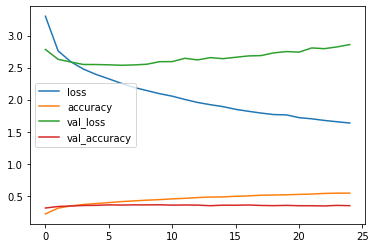

In [21]:
pd.DataFrame(history.history).plot()

In [22]:
resnet_model.evaluate(X_test,y_test)

313/313 [==============================] - 5s 15ms/step - loss: 2.5121 - accuracy: 0.3632


[2.5120630264282227, 0.36320000886917114]